In [12]:
import cv2
from matplotlib import pyplot as plt
from lane_detection import Line
import lane_detection
import lane_following
import numpy as np

In [13]:
IP_ADDRESS = "192.168.1.102"

In [14]:
# vcap = cv2.VideoCapture(f"rtsp://{IP_ADDRESS}:8554/rovcam")

# img = None

# MAX_RETRY = 100
# count = 0
# while count < MAX_RETRY:
#     count += 1
#     # Obtain the frame
#     ret, frame = vcap.read()

#     # Check frame was received successfully
#     if ret:
#         # got a frame, close the cap and return the frame
#         print(" got a frame ")
#         img = frame
#         vcap.release()

# vcap.release()
# if type(img) is not None:
#     cv2.imwrite("frame_from_auv.jpg", img)

In [15]:
# if type(img) is None:
#     pass
# else:
#     frame = img.copy()
frame = cv2.imread("frame_from_auv.jpg")

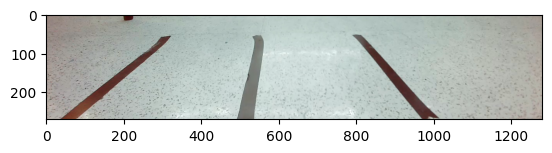

In [16]:
# sliced_frame = frame[ int(frame.shape[0] / 2) : frame.shape[0]]
sliced_frame = frame[450 : frame.shape[0]]
plt.imshow(sliced_frame)

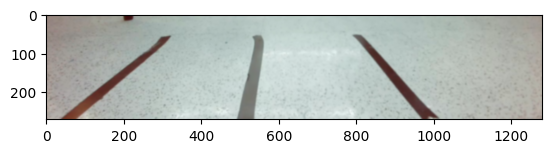

In [17]:
gray = cv2.cvtColor(sliced_frame, cv2.COLOR_BGR2GRAY)  # convert to grayscale
gray = cv2.GaussianBlur(sliced_frame, (9, 9), 0)
plt.imshow(gray)


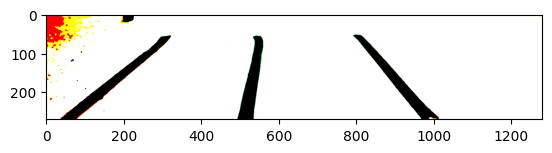

In [18]:
ret,bw_image = cv2.threshold(gray, 140, 255, cv2.THRESH_BINARY)
plt.imshow(bw_image)


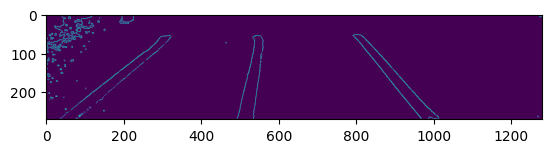

In [19]:
edges = cv2.Canny(
    bw_image, 50, 50, apertureSize=3
)  # detect edges
plt.imshow(edges)


len(lines) = 11


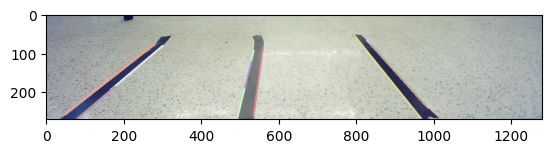

In [20]:
lines = cv2.HoughLinesP(
    edges,
    rho=1,
    theta=np.pi / 180,
    threshold=50,
    minLineLength=10,
    maxLineGap=20,
)  # detect lines

lines = [Line(line[0][0], line[0][1], line[0][2], line[0][3]) for line in lines]
# lines = lane_detection.merge_colinear_lines(lines)
print(f"{len(lines) = }")
drawn = lane_detection.draw_lines(sliced_frame, lines)

plt.imshow(cv2.cvtColor(drawn, cv2.COLOR_BGR2RGB))
plt.show()

In [21]:
import math
def detect_lanes(lines: list[Line], height: int = 1080, width: int = 1920, center_lane_tol = 0.5, parallel_tol = 0.5, x_intercept_tol = 250) -> list[tuple[Line, Line]]:
    center = width / 2
    lanes = []
    lines.sort(key=lambda x: x.x_intercept)

    for i in range(len(lines[:-1])):
        line1 = lines[i]
        for j in range(i+1, len(lines[:-1])):
            line2 = lines[j]
            if line1.is_paired() or line2.is_paired():
                print("lines are paired")
                break

            if math.isclose(line1.slope, -1 * line2.slope, rel_tol=center_lane_tol):
                # lines are a lane near the center
                line1.paired = True
                line2.paired = True
                lanes.append((line1, line2))
                break # line 1 has a match with line 2, so pick a new line 1

            elif math.isclose(line1.slope, line2.slope, rel_tol=parallel_tol):
                # slopes are close to parallel
                if math.isclose(
                    line1.x_intercept, line2.x_intercept, rel_tol=x_intercept_tol
                ):
                    # x-intercepts are close
                    if ((line1.x_intercept > center) and (line2.x_intercept > center)) or (
                        (line1.x_intercept < center) and (line2.x_intercept < center)
                    ):
                        # the lines are probably a pair
                        line1.paired = True
                        line2.paired = True
                        lanes.append((line1, line2))
                        break # found a pair, so start a new
    return lanes

lines are paired
lines are paired
lines are paired
lines are paired
Center x_intercept: 292.5
turn right
The AUV should go to the left


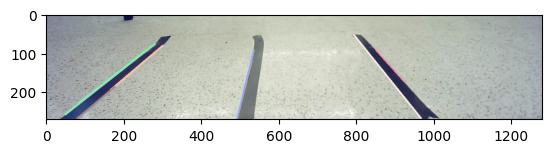

In [22]:
lanes = detect_lanes(lines, sliced_frame.shape[0], sliced_frame.shape[1])
laned_img = lane_detection.draw_lanes(sliced_frame, lanes)
plt.imshow(cv2.cvtColor(laned_img, cv2.COLOR_BGR2RGB))

(center_slope, center_intercept) = lane_following.get_lane_center(lanes)

direction = lane_following.recommend_direction(center_intercept, center_slope, sliced_frame.shape[1])

print(f"The AUV should go to the {direction}")